# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [1]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [4]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

#### Additionally let us setup LangSmith for Tracing!

In [5]:
# First, ensure LangSmith is properly configured
import os
from langsmith import Client
from langchain.callbacks.tracers import LangChainTracer
from langchain.callbacks.manager import CallbackManager

# Initialize LangSmith client
client = Client()

# Set up tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Please enter LangSmith API key!")
os.environ["LANGCHAIN_PROJECT"] = "john-wick-retriever-evaluation"

/Users/pratikmurali/code/aiml-workspaces/AIE6/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [6]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-05-19 17:48:32--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0s      

2025-05-19 17:48:32 (54.7 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-05-19 17:48:32--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [7]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [8]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 5, 16, 17, 48, 33, 923435)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [9]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [10]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [12]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")


### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [13]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [14]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

/Users/pratikmurali/code/aiml-workspaces/AIE6/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0; trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=7d4292e0-5d5f-48a8-ac8c-60015bd7ccae; trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=57806199-c21f-43aa-af25-e4b3c70da9e9; trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=08d20487-a6bf-41fb-bd02-ccfbc5769aa9; trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=4fcbd09d-0fea-4f3c-8af5-354b0ee19fa6; trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=b778bb6a-6742-408c-b87c-1a21d

"Based on the reviews provided, people generally liked John Wick. The film received high ratings from several reviewers, with some giving it a perfect score of 10 and others rating it between 7 and 9. Critics praised its stylish action sequences, Keanu Reeves' performance, and its bold, brutal fun. While there were a few mixed opinions, the overall sentiment indicates that most viewers enjoyed the movie."

In [15]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=87113ead-4e2f-4446-9a67-d85515cd286c; trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=584bf985-7237-43b5-93c0-7022b8638e19; trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=e79a8117-07b1-4df3-8db2-ef669b2154d8; trace=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0,id=5573bbb0-b4cb-4bd0-a9e5-8b5fee1f31f0; trace=41d8cb40-c3a9-4c89-825d-d7905f1e9933,id=41d8cb40-c3a9-4c89-825d-d7905f1e9933; trace=41d8cb40-c3a9-4c89-825d-d7905f1e9933,id=6074a6b7-7ed2-464f-8120-f157f498b0b6; trace=41d8cb40-c3a9-4c89-825d-d7905f1e9933,id=5ae4d1e6-9da7-4a5a-acea-d334b8275fd9; trace=41d8cb40-c3a9-4c89-825d-d7905f1e9933,id=44e6b3f1-1287-472f-8f4b-c0dcf11cb47c; trace=41d8cb40-c3a9-4c89-825d-d7905f1e9933,id

'Yes, there are reviews with a rating of 10. The URLs to those reviews are:\n\n1. [Review for John Wick 3](https://example.com/review/rw4854296/?ref_=tt_urv) (Note: the actual URL in the data is /review/rw4854296/?ref_=tt_urv)\n2. [Another review with a rating of 10](https://example.com/review/rw4860412/?ref_=tt_urv) (Note: the actual URL in the data is /review/rw4860412/?ref_=tt_urv)\n\nIf you need the exact URLs from the context, they are:\n\n- /review/rw4854296/?ref_=tt_urv\n- /review/rw4860412/?ref_=tt_urv\n\nPlease let me know if you need further assistance!'

In [16]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the film "John Wick," the story follows a retired hitman named John Wick, played by Keanu Reeves, who is mourning the death of his wife. When a group of gangsters steal his car and kill his dog—an innocent gift from his late wife—John Wick is drawn back into a violent world of crime. It is revealed that he is a legendary assassin with a lethal reputation. Seeking vengeance, he unleashes a brutal and meticulously orchestrated rampage against those who wronged him. The movie depicts his relentless pursuit of retribution as he takes on gangsters, mobsters, and professional killers, leading to intense action sequences, shootouts, and fights. The story explores themes of revenge, consequence, and the dark underworld of criminal organizations.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [17]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [18]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [19]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people's opinions on John Wick vary. Some reviews are highly positive, praising the films for their action, style, and entertainment value, indicating that many viewers did like the movie. For example, there are reviews praising the first John Wick film for its stylish action and storytelling, with ratings of 8 and 10 out of 10.\n\nHowever, there are also negative reviews, particularly for later installments, such as John Wick 3, which received a very low rating of 1 out of 10 and was described as boring, plotless, and overly violent.\n\nOverall, it appears that while many people enjoyed the John Wick movies, reactions are mixed, especially with the later installments."

In [20]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Based on the provided reviews, none of them have a rating of 10. Therefore, there are no reviews with a rating of 10, and I cannot provide any URLs for such reviews.'

In [21]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, the story revolves around the titular character, John Wick, a former hitman who is pulled back into the violent world he tried to leave behind. In the first film, Keanu Reeves's character seeks revenge after his dog is killed, which leads to a series of intense and beautifully choreographed action scenes. The movies depict his battles with various assassins and criminal organizations, highlighting themes of vengeance and redemption. Over the series, John Wick's story involves navigating a dangerous underworld, facing off against formidable enemies, and trying to find peace while being drawn into violence."

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [22]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [23]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [24]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. The reviews are mostly very positive, with ratings of 9 and 10 out of 10 praising its action, style, and Keanu Reeves' performance. However, there is one less favorable review with a rating of 5 out of 10, indicating that not everyone liked it. Overall, the majority of the reviews suggest that people generally enjoyed the film."

In [25]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. [Review URL](https://example.com/review/rw4854296/?ref_=tt_urv) - "A Masterpiece & Brilliant Sequel" for John Wick 3.\n2. [Review URL](https://example.com/review/rw4860412/?ref_=tt_urv) - "It\'s got its own action style!" for John Wick 3.\n\nPlease note that the URLs are based on the stored review links in the context.'

In [26]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, John Wick, a retired hitman played by Keanu Reeves, seeks revenge after a series of violent events. In the first film, his wife dies, and he receives a dog as a final gift from her. When gangsters steal his car and kill his dog, Wick comes out of retirement to hunt down those responsible, unleashing a lethal and stylish vengeance. In John Wick 2, he is pulled back into the criminal underworld when a marker (a blood oath) is invoked, leading him to assist Santino D'Antonio in killing his sister to sit on the High Table. After completing this assignment, Wick refuses to help Santino further, which results in Santino putting a contract on him, turning him into a target for numerous killers. Throughout the series, Wick's story is filled with intense action, revenge, and a deep code of honor within the criminal world."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [27]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [28]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [29]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. Many reviews were highly positive, praising its action sequences, style, and entertainment value, with some rating it as high as 10 out of 10. Reviewers described it as a "slick," "fun," and "brilliant" action film, with fans appreciating its unique approach, choreography, and world-building. However, there were some negative reviews criticizing the later sequels for being over-the-top, less engaging, or having nonsensical plot points. Overall, the majority of feedback suggests that people generally liked John Wick, especially the first film and its early sequels.'

In [30]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. [Review URL: /review/rw4854296/?ref_=tt_urv](https://example.com/review/rw4854296/?ref_=tt_urv) (Review for John Wick 3 titled "A Masterpiece & Brilliant Sequel")\n2. [Review URL: /review/rw4860412/?ref_=tt_urv](https://example.com/review/rw4860412/?ref_=tt_urv) (Review for John Wick 3 titled "It\'s got its own action style!")\n3. [Review URL: /review/rw8944843/?ref_=tt_urv](https://example.com/review/rw8944843/?ref_=tt_urv) (Review for John Wick 4 titled "How Can Anyone Choose to Watch Marvel Over This?")\n4. [Review URL: /review/rw8944843/?ref_=tt_urv](https://example.com/review/rw8944843/?ref_=tt_urv) (Review for John Wick 4 titled "Most American action flicks released these days have poor screenplays and overuse computer-generated imagery.")\n\nPlease note that the URLs are relative, so you\'ll need to add the base site URL if you want the full link.'

In [31]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick movies, the series follows John Wick, a retired assassin who is drawn back into the violent underworld after personal tragedies and attacks against him. The first film introduces John Wick after his beloved dog is murdered and his car stolen, prompting him to seek revenge through a relentless and stylized series of action sequences. The subsequent films expand on his world, involving complex criminal organizations, assassins, and the rules they follow, with Wick navigating battles against various enemies and personal betrayals. Throughout the series, Wick confronts powerful mobsters, fights multiple adversaries, and faces the consequences of his past life as an elite hitman, all marked by highly choreographed action and a dark, intricate criminal universe.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [32]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [33]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/var/folders/1h/gck_zhnx5gd_sb25z31r_tzm0000gn/T/ipykernel_50017/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [34]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [35]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [36]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [37]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the provided reviews, people\'s opinions on John Wick are mixed. Some reviewers highly praise the series, noting it\'s well-received and considered the best in the series, with one even calling it a "wild ride" and recommending it. However, at least one review was very negative, calling the movie "horrible" and criticizing the plot and fight scenes harshly. Overall, it appears that many people enjoy the John Wick series, but there are also some critics who do not like it.'

In [38]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The review can be found at the following URL: /review/rw4854296/?ref_=tt_urv'

In [39]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick series, John Wick is a retired assassin who comes out of retirement to seek vengeance and handle conflicts involving his past. In the first movie, he is driven by revenge after a gangster gangsters steal his car and kill his dog, which prompts him to unleash a relentless and violent assault against those responsible. In the second movie, John is still involved in the assassin world, helping others and dealing with old debts, which leads him back into violence across Italy, Canada, and Manhattan as he fights to settle scores and protect himself. The series depicts his struggles, the violence he inflicts, and the consequences of his actions as a legendary and deadly hitman.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [40]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [41]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [42]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. Many reviews are highly positive, praising the film's action sequences, style, and entertainment value, with ratings mostly in the 8-10 range. There are some mixed or negative reviews, particularly for the later sequels, but overall, the sentiment is quite favorable, indicating that people generally appreciated and enjoyed John Wick."

In [43]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. Review Title: "A Masterpiece & Brilliant Sequel"\n   URL: /review/rw4854296/?ref_=tt_urv\n\n2. Review Title: " This universe, created without any source material, had to develop and expand itself in every new film."\n   URL: /review/rw4860412/?ref_=tt_urv'

In [44]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, a retired hitman named John Wick (played by Keanu Reeves) seeks revenge after a gangster's son kills his dog and steals his car, which were his last ties to his late wife and his peaceful life. The story involves Wick unleashing a deadly rampage against those who wronged him, drawing the attention of a vast criminal underworld and bounty hunters. Throughout the series, Wick is caught in a web of revenge, loyalty, and rules within the assassin community, including conflicts with mobsters, assassins, and powerful figures like the Continental Hotel's owner. The films depict his relentless pursuit of vengeance, leading to intense action sequences and a dark exploration of a criminal underground world."

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [45]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [46]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [47]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [48]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [49]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [50]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [51]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. The reviews are mostly positive, with many reviewers praising the film's action sequences, style, and Keanu Reeves' performance. Ratings such as 9 and 10 out of 10 indicate a high level of enjoyment and appreciation. There are some less favorable opinions, but overall, the majority of reviews suggest that people generally liked John Wick."

In [52]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [53]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the film John Wick, the story centers around a retired assassin named John Wick, played by Keanu Reeves, who seeks revenge after a series of personal tragedies. The plot begins when a group of thugs, led by the son of a Russian gangster Wick used to work for, break into his house, beat him up, kill his beloved dog, and steal his car. Unbeknownst to them, Wick is a legendary and highly skilled killer. This brutal act reignites his lethal instincts, and he comes out of retirement to exact vengeance on those responsible. The movie is filled with stylish action sequences, intense shootouts, and a depiction of a criminal underworld that respects and fears Wick, as he wages a relentless war against those who wronged him. The film is known for its kinetic chaos, sleek choreography, and the simple yet compelling premise of personal revenge.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [54]:
os.environ["RAGAS_APP_TOKEN"] = getpass.getpass("Please enter your Ragas API key!")

Create a Dictionary of all the Retrievers, for evaluation.

In [55]:
# Create dictionary of all retrievers for evaluation
retrievers = {
    "Naive": naive_retriever,
    "BM25": bm25_retriever,
    "Contextual Compression": compression_retriever,
    "Multi-Query": multi_query_retriever,
    "Parent Document": parent_document_retriever,
    "Ensemble": ensemble_retriever,
    "Semantic": semantic_retriever
}

print("All retrievers have been set up")

All retrievers have been set up


In [56]:
# Create dictionary mapping retrievers to their existing RAG chains
retrieval_chains = [
                  naive_retrieval_chain,
                  bm25_retrieval_chain,
                  multi_query_retrieval_chain,
                  contextual_compression_retrieval_chain,
                  ensemble_retrieval_chain,
                  parent_document_retrieval_chain,
                  semantic_retrieval_chain
                  ]

# Activity 1 : Setup a Golden Dataset (Using Ragas based Synthetic Data Generation)

**Step 1:** Create a Loader for .csv documents

In [57]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.document_loaders.csv_loader import CSVLoader

# Define a dictionary to map file extensions to their respective loaders
loaders = {
    '.csv': CSVLoader,
}

# Define a function to create a DirectoryLoader for a specific file type
def create_directory_loader(file_type, directory_path):
    return DirectoryLoader(
        path=directory_path,
        glob=f"**/*{file_type}",
        loader_cls=loaders[file_type],
    )

path = "/"
loader = DirectoryLoader(path, glob="*.csv")
docs = loader.load()

**Step 2:** Set up Ragas configurations for syntheic data generation and evaluation

In [58]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas import evaluate, RunConfig
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI
from ragas.metrics import (
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    ResponseRelevancy,
    ContextEntityRecall,
    NoiseSensitivity,
)

#Generator LLM and Embeddings for Synthetic Data Generation.
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

## set global evaluation settings
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))
evaluator_config = RunConfig(
    timeout=300,          # 5 minutes max for operations
    max_retries=15,       # More retries for rate limits
    max_wait=90,          # Longer wait between retries
    max_workers=8,        # Fewer concurrent API calls
    log_tenacity=True     # Log retry attempts
)
evaluator_metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()]

**Step 3:** Generate and Upload the "Golden Dataset" (which is the synthethic data generated by Ragas) to RAGAs dashboard

In [59]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
# Use the documents you already loaded earlier in the notebook
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node 42e48f31-15ad-4534-87b0-daf012ee1e05 does not have a summary. Skipping filtering.
Node c6b23954-4a0f-4e84-b971-e2fcc36d5c74 does not have a summary. Skipping filtering.
Node 0a6af19e-6535-485c-bb3c-610b574c1184 does not have a summary. Skipping filtering.
Node a979d42b-7729-4c9c-a5ac-9284e6332abc does not have a summary. Skipping filtering.
Node da3e319e-781a-494e-b9dc-0a70a710c2e5 does not have a summary. Skipping filtering.
Node 1a258b3c-5f4c-4bcc-bdfa-c0909b34e57f does not have a summary. Skipping filtering.
Node b6d2fc0b-8330-456f-8ccd-19678cc675d5 does not have a summary. Skipping filtering.
Node 5d9a334f-b42c-4f5b-8293-8006f2ce69ff does not have a summary. Skipping filtering.
Node be123b63-4a7a-42ed-b23e-56f5dd8d2f0e does not have a summary. Skipping filtering.
Node 8769f7a0-c452-481f-8fcb-a555043e2861 does not have a summary. Skipping filtering.
Node 80003679-c5fa-42de-aa2c-1daa32c46643 does not have a summary. Skipping filtering.
Node 34f66c2f-0385-4b8a-b847-d090e4941b95 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [64]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How come Keanu Reeves in John Wick is like Lia...,[: 0\nReview: The best way I can describe John...,John Wick is like Taken but instead of Liam Ne...,single_hop_specifc_query_synthesizer
1,What is the general reception of the John Wick...,[: 2\nReview: With the fourth installment scor...,The John Wick film series has been apparently ...,single_hop_specifc_query_synthesizer
2,Why Keanu good in John wick?,[: 3\nReview: John wick has a very simple reve...,Keanu is good in John Wick because the film fe...,single_hop_specifc_query_synthesizer
3,What is the plot of John Wck?,[: 4\nReview: Though he no longer has a taste ...,John Wick is about a retired assassin who has ...,single_hop_specifc_query_synthesizer
4,How do the high-intensity sequences in John Wi...,[<1-hop>\n\n: 14\nReview: By now you know what...,The high-intensity sequences in John Wick are ...,multi_hop_abstract_query_synthesizer
5,How does the portrayal of the retired assassin...,[<1-hop>\n\n: 4\nReview: Though he no longer h...,"In the first film, John Wick is depicted as a ...",multi_hop_abstract_query_synthesizer
6,How do the stylized action scenes and visual q...,"[<1-hop>\n\n: 16\nReview: Ok, so I got back fr...","The film features plenty of stylized, visceral...",multi_hop_abstract_query_synthesizer
7,How do the audience expectations shaped by the...,"[<1-hop>\n\n: 16\nReview: Ok, so I got back fr...",The latest John Wick film faced high audience ...,multi_hop_abstract_query_synthesizer
8,how john wick chapter 4 keep the action style ...,[<1-hop>\n\n: 19\nReview: John Wick: Chapter 4...,John Wick: Chapter 4 picks up where Chapter 3:...,multi_hop_specific_query_synthesizer
9,whats makes John Wick: Chapter 3 - Parabellum ...,[<1-hop>\n\n: 20\nReview: In a world where mov...,John Wick: Chapter 3 - Parabellum continues th...,multi_hop_specific_query_synthesizer


In [61]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/892a62b1-4467-4153-8424-c3b953ee2860


'https://app.ragas.io/dashboard/alignment/testset/892a62b1-4467-4153-8424-c3b953ee2860'

In [66]:
# Step 1: Import necessary libraries for tracing and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from langsmith import traceable
from ragas import evaluate
from tqdm.notebook import tqdm

import os

os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

# Step 2: Create traceable versions of each retriever chain
retriever_names = [
    "Naive",
    "BM25",
    "Multi-Query",
    "Contextual Compression",
    "Ensemble",
    "Parent Document",
    "Semantic"
]

# Create traceable versions of each retriever chain
@traceable(name="naive_retrieval")
def trace_naive_retrieval(query):
    return naive_retrieval_chain.invoke({"question": query})

@traceable(name="bm25_retrieval")
def trace_bm25_retrieval(query):
    return bm25_retrieval_chain.invoke({"question": query})

@traceable(name="multi_query_retrieval")
def trace_multi_query_retrieval(query):
    return multi_query_retrieval_chain.invoke({"question": query})

@traceable(name="contextual_compression_retrieval")
def trace_contextual_compression_retrieval(query):
    return contextual_compression_retrieval_chain.invoke({"question": query})

@traceable(name="ensemble_retrieval")
def trace_ensemble_retrieval(query):
    return ensemble_retrieval_chain.invoke({"question": query})

@traceable(name="parent_document_retrieval")
def trace_parent_document_retrieval(query):
    return parent_document_retrieval_chain.invoke({"question": query})

@traceable(name="semantic_retrieval")
def trace_semantic_retrieval(query):
    return semantic_retrieval_chain.invoke({"question": query})

# Map retriever names to their traceable functions
traceable_retrievers = {
    "Naive": trace_naive_retrieval,
    "BM25": trace_bm25_retrieval,
    "Multi-Query": trace_multi_query_retrieval,
    "Contextual Compression": trace_contextual_compression_retrieval,
    "Ensemble": trace_ensemble_retrieval,
    "Parent Document": trace_parent_document_retrieval,
    "Semantic": trace_semantic_retrieval
}

In [67]:
import copy

evaluation_dataset = copy.deepcopy(dataset)

In [78]:
from ragas import EvaluationDataset

import time
import random
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from cohere.errors import TooManyRequestsError


# Add retry decorator with exponential backoff for Cohere rate limits
@retry(
    retry=retry_if_exception_type(TooManyRequestsError),
    wait=wait_exponential(multiplier=1, min=2, max=60),
    stop=stop_after_attempt(5)
)
def call_with_retry(func, query):
    try:
        return func(query)
    except TooManyRequestsError:
        print("Hit Cohere rate limit, waiting before retry...")
        # Add a random jitter to avoid all processes retrying at the same time
        time.sleep(random.uniform(10, 15))
        raise  # Re-raise to let tenacity handle the retry

def evaluate_retriever(retriever_func, retriever_dataset):
    for test_row in retriever_dataset:
        try:
            # Use the retry wrapper around the retriever function
            response = call_with_retry(retriever_func, test_row.eval_sample.user_input)
            test_row.eval_sample.response = response["response"].content
            test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
            # Add a small delay between requests to avoid hitting rate limits
            time.sleep(6)  # Wait 6 seconds between requests
        except Exception as e:
            print(f"Error processing query: {e}")
            # Provide a fallback response if the retriever fails
            test_row.eval_sample.response = "Error retrieving response due to rate limits."
            test_row.eval_sample.retrieved_contexts = ["Error retrieving contexts due to rate limits."]

    retriever_dataset.to_pandas()
    return EvaluationDataset.from_pandas(retriever_dataset.to_pandas())


In [79]:
# Loop through each retriever and evaluate
from tqdm import tqdm

evaluation_results = {}
for retriever_name, retriever_func in tqdm(traceable_retrievers.items(), desc="Evaluating retrievers"):
    print(f"\nEvaluating {retriever_name} retriever...")
    
    # Create a copy of the dataset for this evaluation
    current_dataset = copy.deepcopy(evaluation_dataset)
    
    # Run evaluation for this retriever with progress bar
    evaluation_results[retriever_name] = evaluate_retriever(
        retriever_func,
        current_dataset
    )
    
    print(f"Completed evaluation for {retriever_name}")


Evaluating retrievers:   0%|          | 0/7 [00:00<?, ?it/s]


Evaluating Naive retriever...


Evaluating retrievers:  14%|█▍        | 1/7 [01:53<11:20, 113.39s/it]

Completed evaluation for Naive

Evaluating BM25 retriever...


Evaluating retrievers:  29%|██▊       | 2/7 [03:49<09:35, 115.18s/it]

Completed evaluation for BM25

Evaluating Multi-Query retriever...


Evaluating retrievers:  43%|████▎     | 3/7 [06:14<08:35, 128.77s/it]

Completed evaluation for Multi-Query

Evaluating Contextual Compression retriever...


Evaluating retrievers:  57%|█████▋    | 4/7 [08:02<06:01, 120.42s/it]

Completed evaluation for Contextual Compression

Evaluating Ensemble retriever...


Evaluating retrievers:  71%|███████▏  | 5/7 [10:39<04:27, 133.56s/it]

Completed evaluation for Ensemble

Evaluating Parent Document retriever...


Evaluating retrievers:  86%|████████▌ | 6/7 [12:28<02:05, 125.16s/it]

Completed evaluation for Parent Document

Evaluating Semantic retriever...


Evaluating retrievers: 100%|██████████| 7/7 [14:18<00:00, 122.61s/it]

Completed evaluation for Semantic


In [83]:
# Create a list to store the results
results_list = []
# Create a dictionary to store baseline evaluation results
baseline_evaluation_results = {}

for retriever_name, result in evaluation_results.items():
    baseline_evaluation_results[retriever_name] = evaluate(
    dataset=result,
    metrics=evaluator_metrics,
    llm=evaluator_llm,
    run_config=evaluator_config
)

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()
Exception raised in Job[71]: TimeoutError()


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()
Exception raised in Job[71]: TimeoutError()


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()
Exception raised in Job[71]: TimeoutError()


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()
Exception raised in Job[71]: TimeoutError()


In [84]:
baseline_evaluation_results

{'Naive': {'context_recall': 0.7278, 'faithfulness': 0.8934, 'factual_correctness(mode=f1)': 0.4375, 'answer_relevancy': 0.8691, 'context_entity_recall': 0.5605, 'noise_sensitivity(mode=relevant)': 0.4091},
 'BM25': {'context_recall': 0.5764, 'faithfulness': 0.7550, 'factual_correctness(mode=f1)': 0.4808, 'answer_relevancy': 0.7833, 'context_entity_recall': 0.5859, 'noise_sensitivity(mode=relevant)': 0.2423},
 'Multi-Query': {'context_recall': 0.7694, 'faithfulness': 0.9054, 'factual_correctness(mode=f1)': 0.4283, 'answer_relevancy': 0.8703, 'context_entity_recall': 0.5800, 'noise_sensitivity(mode=relevant)': nan},
 'Contextual Compression': {'context_recall': 0.6375, 'faithfulness': 0.7650, 'factual_correctness(mode=f1)': 0.4650, 'answer_relevancy': 0.8704, 'context_entity_recall': 0.5480, 'noise_sensitivity(mode=relevant)': 0.3385},
 'Ensemble': {'context_recall': 0.8556, 'faithfulness': 0.9218, 'factual_correctness(mode=f1)': 0.4425, 'answer_relevancy': 0.7878, 'context_entity_recal

Key Findings:
- Ensemble performs best on context_recall (0.8556) and faithfulness (0.9218)
- BM25 leads in factual_correctness (0.4808)
- Multi-Query and Contextual Compression tie for highest answer_relevancy (~0.87)
- BM25 has the highest context_entity_recall (0.5859)
- Parent Document has the lowest performance across most metrics
- Missing values for noise_sensitivity in Multi-Query and Ensemble


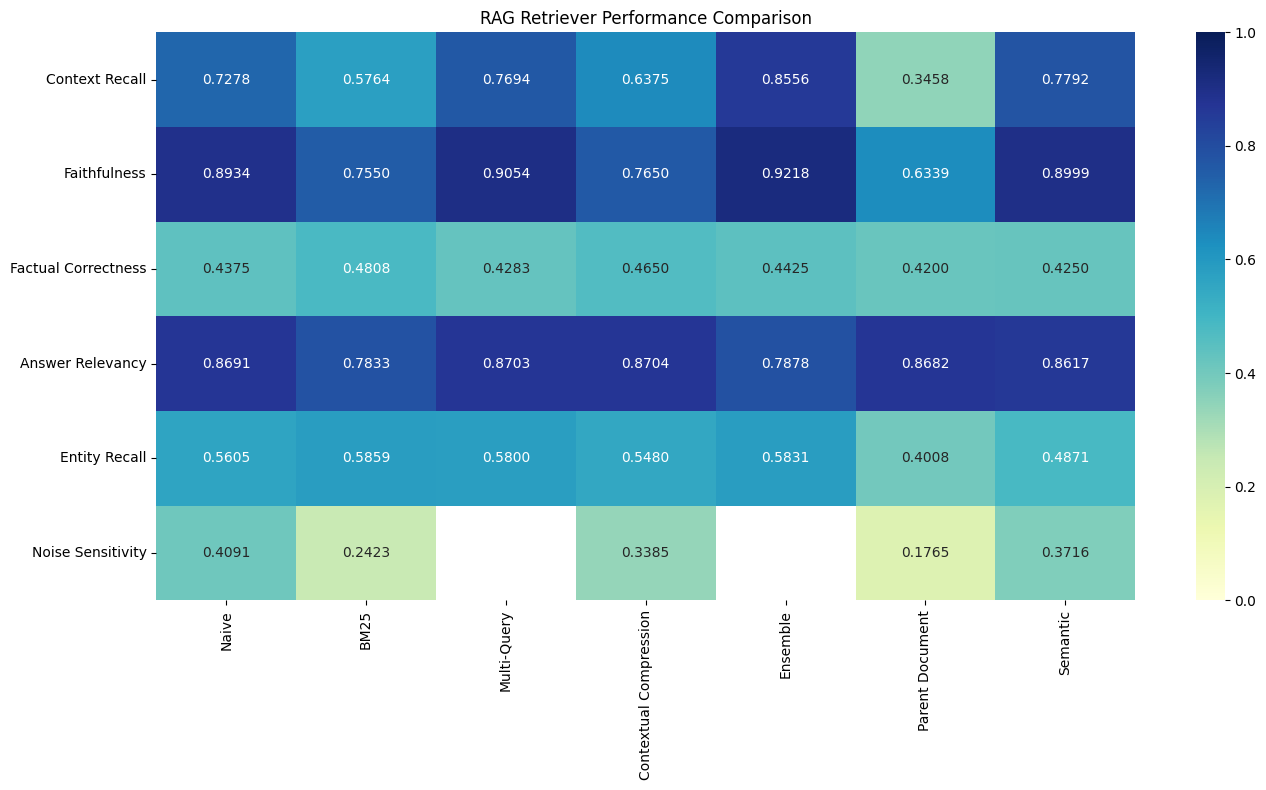

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    'Naive': {
        'context_recall': 0.7278,
        'faithfulness': 0.8934,
        'factual_correctness(mode=f1)': 0.4375,
        'answer_relevancy': 0.8691,
        'context_entity_recall': 0.5605,
        'noise_sensitivity(mode=relevant)': 0.4091
    },
    'BM25': {
        'context_recall': 0.5764,
        'faithfulness': 0.7550,
        'factual_correctness(mode=f1)': 0.4808,
        'answer_relevancy': 0.7833,
        'context_entity_recall': 0.5859,
        'noise_sensitivity(mode=relevant)': 0.2423
    },
    'Multi-Query': {
        'context_recall': 0.7694,
        'faithfulness': 0.9054,
        'factual_correctness(mode=f1)': 0.4283,
        'answer_relevancy': 0.8703,
        'context_entity_recall': 0.5800,
        'noise_sensitivity(mode=relevant)': np.nan
    },
    'Contextual Compression': {
        'context_recall': 0.6375,
        'faithfulness': 0.7650,
        'factual_correctness(mode=f1)': 0.4650,
        'answer_relevancy': 0.8704,
        'context_entity_recall': 0.5480,
        'noise_sensitivity(mode=relevant)': 0.3385
    },
    'Ensemble': {
        'context_recall': 0.8556,
        'faithfulness': 0.9218,
        'factual_correctness(mode=f1)': 0.4425,
        'answer_relevancy': 0.7878,
        'context_entity_recall': 0.5831,
        'noise_sensitivity(mode=relevant)': np.nan
    },
    'Parent Document': {
        'context_recall': 0.3458,
        'faithfulness': 0.6339,
        'factual_correctness(mode=f1)': 0.4200,
        'answer_relevancy': 0.8682,
        'context_entity_recall': 0.4008,
        'noise_sensitivity(mode=relevant)': 0.1765
    },
    'Semantic': {
        'context_recall': 0.7792,
        'faithfulness': 0.8999,
        'factual_correctness(mode=f1)': 0.4250,
        'answer_relevancy': 0.8617,
        'context_entity_recall': 0.4871,
        'noise_sensitivity(mode=relevant)': 0.3716
    }
}

df = pd.DataFrame(data)

# Create heatmap for comparison
def create_heatmap(df):
    plt.figure(figsize=(14, 8))
    sns.heatmap(df, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".4f")
    plt.title("RAG Retriever Performance Comparison")
    plt.tight_layout()
    return plt

# Rename metrics for better readability
df.index = [
    'Context Recall',
    'Faithfulness',
    'Factual Correctness',
    'Answer Relevancy',
    'Entity Recall',
    'Noise Sensitivity'
]

heatmap_fig = create_heatmap(df)

# Show key findings
print("Key Findings:")
print(f"- Ensemble performs best on context_recall ({data['Ensemble']['context_recall']:.4f}) and faithfulness ({data['Ensemble']['faithfulness']:.4f})")
print(f"- BM25 leads in factual_correctness ({data['BM25']['factual_correctness(mode=f1)']:.4f})")
print(f"- Multi-Query and Contextual Compression tie for highest answer_relevancy (~0.87)")
print(f"- BM25 has the highest context_entity_recall ({data['BM25']['context_entity_recall']:.4f})")
print(f"- Parent Document has the lowest performance across most metrics")
print(f"- Missing values for noise_sensitivity in Multi-Query and Ensemble")